In [49]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import models, layers

In [50]:
# DATASET_PATH = 'data/mini_speech_commands'
DATASET_PATH = 'mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

In [51]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    # Directory data
    directory = data_dir,
    # Jumlah sample dalam satu batch
    batch_size = 64,
    # Train 70%, Validation 30% (50-50 untuk validation dan test)
    validation_split = 0.3,
    seed = 0,
    output_sequence_length = 16000,
    subset = 'both'
)

Found 8000 files belonging to 8 classes.
Using 5600 files for training.
Using 2400 files for validation.


In [52]:
# Datakan ada name label apa saja dari dataset

label_names = np.array(train_ds.class_names)
print(label_names)

['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [53]:
# Squeeze -> untuk hilangin axis terakhir audio -> audio dibuat jadi Mono
# (num_samples, num_channels) -> (num_samples, )

def squeeze(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

# Autotune -> kontrol berapa banyak calls yang bisa dijalankan secara paralel/bersamaan berdasarkan resource yang ada
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [54]:
# Split validation using Shard
# Digunakan ketika dataset dibagi untuk validation 30%, tetapi di soal diminta 15% validation dan 15% test

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# Val_ds terpecah menjadi dua, test_ds ambil 50% pertama dari validation 30% tersebut, val_ds ambil 50% terakhir
# Dataset sekarang terbagi menjadi 70% training, 15% validation, 15% testing

In [55]:
# Buat spectrogram dari waveform

def get_spectrogram(waveform):
    # STFT -> Short Time Fourier Transform
    spectrogram = tf.signal.stft(
        waveform,
        frame_length=255,
        frame_step=128
    )

    # Ambil amplitudo-nya
    spectrogram = tf.abs(spectrogram)

    # Tambahkan satu axis/dimensi supaya bisa di-feed ke model CNN
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

# Function tambahan untuk mempermudah apply/call function spectrogram
def make_spec_ds(ds):
    return ds.map(
        # Aplikasikan lambda function untuk panggil fungsi get_spectrogram()
        map_func = lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls = tf.data.AUTOTUNE
    )

In [56]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# Optimization (cache & AUTOTUNE) dan shuffle
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [57]:
# Ambil salah satu batch data
for example_sc, example_sc_lbl in train_spectrogram_ds.take(1):
    break

In [58]:
# Arsitektur CNN:
# Input layer -> entry point data ke dalam model, termasuk preprocess data sebelum dilanjutkan ke hidden layer, dan harus disesuaikan dengan mengikuti shape dari spectrogram yang di-feed ke model
# Hidden layer -> inti dari model, terdiri dari resize, convolution layer, MaxPooling, dsb. 
# Output layer -> umumnya berupa Dense layer (fully-connected layer), perlu disesuaikan dengan banyaknya label atau jenis output

# Sesuaikan input shape dengan shape spectrogram
input_shape = example_sc.shape[1:]

norm_layer = layers.Normalization()
# Dipasangi lambda function karena hanya butuh spectrogramnya saja, tidak perlu ambil labelnya
norm_layer.adapt(data=train_spectrogram_ds.map(map_func = lambda spec, label: spec))

model = models.Sequential([
    # Input layer
    layers.Input(shape=input_shape),
    # Resize layer -> untuk resize spectrogram supaya seragam
    layers.Resizing(32, 32),
    # Normalization layer -> supaya data berada dalam satu range yang sama
    norm_layer,
    # Hidden layer -> MaxPooling, Dropout, Convolution -> menghasilkan 32 basic pattern dari setiap spectrogram
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    # MaxPooling -> untuk ekstrak fitur/pattern yang dominan, sehingga mencegah overfitting
    layers.MaxPooling2D(),
    # Dropout -> randomly drop data untuk mencegah model mengalami overfitting
    layers.Dropout(0.2),
    # Flatten layer
    layers.Flatten(),
    # Dense layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    # Output layer -> sesuaikan dengan jumlah label
    layers.Dense(len(label_names))
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [59]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [60]:
EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.3237 - loss: 1.8450 - val_accuracy: 0.5287 - val_loss: 1.2658
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.6273 - loss: 1.0800 - val_accuracy: 0.6867 - val_loss: 0.8819
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7569 - loss: 0.7161 - val_accuracy: 0.7483 - val_loss: 0.7824
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8238 - loss: 0.5360 - val_accuracy: 0.7669 - val_loss: 0.6988
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8478 - loss: 0.4492 - val_accuracy: 0.7931 - val_loss: 0.6599
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8822 - loss: 0.3474 - val_accuracy: 0.7931 - val_loss: 0.6515
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8990 - loss: 0.2914 - val_accuracy: 0.8133 - val_loss: 0.5985
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9201 - loss: 0.2452 - val_accuracy: 0.8142 - v

In [61]:
# Predict

# model.predict akan mengembalikan logits/probability dari setiap class
y_pred = model.predict(test_spectrogram_ds)

# Ambil probability yang terbesar, tapi masih berbentuk index (numerik)
y_pred = tf.argmax(y_pred, axis=1)

# Convert jadi labels
def convert_to_label(labels):
    real_labels = []
    for label in labels:
        real_labels.append(label_names[label.numpy()])
    return real_labels

# Data True
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [62]:
y_pred = convert_to_label(y_pred)
y_true = convert_to_label(y_true)

for idx in range(len(y_pred)):
    print(f"Data {idx+1} : Original Label '{y_true[idx]}' - Prediction '{y_pred[idx]}'")

Data 1 : Original Label 'down' - Prediction 'left'
Data 2 : Original Label 'left' - Prediction 'left'
Data 3 : Original Label 'up' - Prediction 'right'
Data 4 : Original Label 'up' - Prediction 'up'
Data 5 : Original Label 'right' - Prediction 'up'
Data 6 : Original Label 'up' - Prediction 'up'
Data 7 : Original Label 'stop' - Prediction 'up'
Data 8 : Original Label 'go' - Prediction 'no'
Data 9 : Original Label 'yes' - Prediction 'yes'
Data 10 : Original Label 'yes' - Prediction 'yes'
Data 11 : Original Label 'right' - Prediction 'right'
Data 12 : Original Label 'left' - Prediction 'left'
Data 13 : Original Label 'go' - Prediction 'no'
Data 14 : Original Label 'up' - Prediction 'up'
Data 15 : Original Label 'right' - Prediction 'right'
Data 16 : Original Label 'no' - Prediction 'no'
Data 17 : Original Label 'no' - Prediction 'no'
Data 18 : Original Label 'go' - Prediction 'go'
Data 19 : Original Label 'stop' - Prediction 'stop'
Data 20 : Original Label 'right' - Prediction 'right'
Dat

In [63]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

accuracy = np.mean(y_pred == y_true)
print('Prediction Accuracy =', accuracy*100, '%')

Prediction Accuracy = 80.67434210526315 %


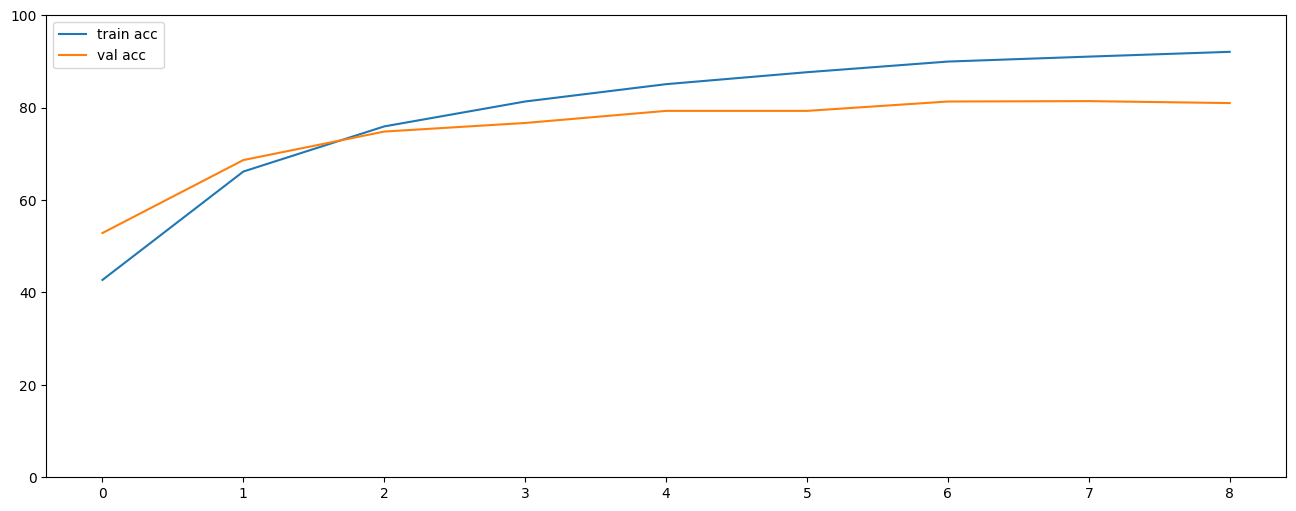

In [64]:
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['train acc', 'val acc'])
plt.ylim([0, 100])
plt.show()